
# Starter's Guide to building a CNN with tensorflow, openCV and google drive for image storage

This guide is meant to be a simple tutorial which lets you take images classes, train a model with tensorflow and then predict a new image with your "intelligent" model.

You can use this python script to get sample training images from a website: https://github.com/ibbad/image-scrapper

To have this notebook work you will need to:
- Have a google drive folder; copy this notebook to it
- Put the notebook and training images in a separate folder e.g. drive/Simple CNN Tutorial/
- Images: https://drive.google.com/drive/folders/1RcWFv-PDtGK4n1JgkAgL77fB-N0I4oMP?usp=sharing

To run this notebook select each cell and click shift+enter on your keyboard, wait until the cell is finished running before going to the next

Below outline the standard import and installation settings for openCV and tensorflow

In [0]:
# #This section is base copy from google's sample import of tensorflow, keras, ploting and support libraries

# #install libraries
# !pip install -q keras
# !pip install -q tqdm

# #openCV
# #openCV is used to process and filter images
# !apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

# #Tensorflow is used to train the neural network which will perform your image recognition
# # To determine which version you're using:
# !pip show tensorflow

# # For the current version: 
# !pip install --upgrade tensorflow

# # For a specific version:
# !pip install tensorflow==1.2

# # For the latest nightly build:
# !pip install tf-nightly

# # http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
  
# # https://github.com/dmlc/xgboost
# # This specific version is a work-around for a build issue in newer versions.
# !pip install -q xgboost==0.4a30

# # https://pypi.python.org/pypi/pydot
# !apt-get -qq install -y graphviz && pip install -q pydot

# # https://pypi.python.org/pypi/libarchive
# !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive

#turicreate lets you setup and run image classifiers without having to create the different layers and have an indepth understanding
# !pip install turicreate

# !pip install urlopen

The CNN training and loading data functions are from:
- https://github.com/Fdevmsy/Image_Classification_with_5_methods/blob/master/src_code/method2/CNN_Image_Classification.ipynb
- http://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/ (good resource for understanding each step below in more detail)

In [184]:
# In this step we import the libraries needed to import files from google drive

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmp32n27e0u/pubring.gpg' created
gpg: /tmp/tmp32n27e0u/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [186]:
# Here we connect to your google drive folder.
# You can download sample puppy and rabbit images using this link: https://drive.google.com/drive/folders/1RcWFv-PDtGK4n1JgkAgL77fB-N0I4oMP?usp=sharing

# WARNING YOU MAY NEED TO RUN THIS CELL MULTIPLE TIMES TO GET A CONNECTION + KEY ESTABLISHED to your google drive.

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()


··········


In [187]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print 'Files in Drive:'
!ls drive/

Files in Drive:
B1 Theme Day Dinner (Responses).ods
B1 Theme Day Dinner.zip
CFD ANSYS FLUENT.cas
Check-In Schedule - Filled In.docx
CHEG345 Junior Lab
CHEG432_Group_S_Level_2_Cumene.docx
CHEG432_Group_S_Level_2_Cumene.docx.odt
CISC220
CISC220Lab7 (69b84fe4).zip
CISC220Lab7 (ab223e1d).zip
CISC220Lab7.zip
Colab Notebooks
Deutschland: Speaking Activity.odt
Duffy'sHope
Duffy’s Hope Final Presentation.pdf
Economic optimization of Computer Chip Design.pdf
Estuaries Game: CISC275 Project.odt
Expense register vs.4.xls
Fluids projects
FullSizeRender.jpg
IMG_0104.MOV
IMG_0105.MOV
IMG_0106.MOV
IMG_0107.MOV
IMG_0110.MOV
IMG_0111.MOV
IMG_9956.jpg
JMPPro-13-1-WIN.exe
Lab5_Garcia_Kothare (17052265).zip
Lab5_Garcia_Kothare (66f1cc37).zip
Lab5_Garcia_Kothare (6d56e84a).zip
Lab5_Garcia_Kothare (a58ce302).zip
Lab5_Garcia_Kothare_errorqs.zip
Lab5_Garcia_Kothare.zip
Lab6_2.zip
Lab6_Garcia_Kothare (bda63d36).zip
Lab6_Garcia_Kothare.zip
Mass and Heat Transfer text.pdf
McCabe-Thiele Diagram.xlsx.ods
Meine Tol

In [0]:
import os
os.chdir("drive/Colab Notebooks/Simple CNN Image Tutorial/")

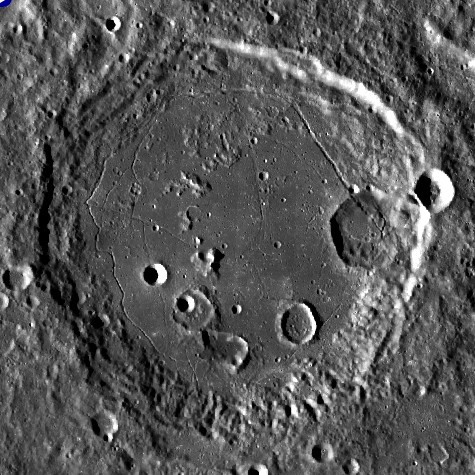

In [189]:
img_folder = 'images'

#1. Get sample file
#2. Read image and display
from IPython.display import Image
Image("GaussCrater.jpg")

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random
import glob
import numpy as np
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

import cv2
from sklearn.utils import shuffle

In [0]:
#Functions for loading training and testing data in a vector format instead of an image

def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:   # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


def load_test(test_path, image_size):
    path = os.path.join(test_path, '*g')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    print("Reading test images")
    for fl in files:
        flbase = os.path.basename(fl)
        img = cv2.imread(fl)
        img = cv2.resize(img, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
        X_test.append(img)
        X_test_id.append(flbase)

### because we're not creating a DataSet object for the test images, normalization happens here
    X_test = np.array(X_test, dtype=np.uint8)
    X_test = X_test.astype('float32')
    X_test = X_test / 255

    return X_test, X_test_id



class DataSet(object):

    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]


        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1

            # # Shuffle the data (maybe)
            # perm = np.arange(self._num_examples)
            # np.random.shuffle(perm)
            # self._images = self._images[perm]
            # self._labels = self._labels[perm]
            # Start next epoch

            start = 0
            self._index_in_epoch = batch_size
            #print (self._num_examples)
            assert batch_size <= self._num_examples
            
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass
    data_sets = DataSets()

    images, labels, ids, cls = load_train(train_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

        validation_images = images[:validation_size]
        validation_labels = labels[:validation_size]
        validation_ids = ids[:validation_size]
        validation_cls = cls[:validation_size]

        train_images = images[validation_size:]
        train_labels = labels[validation_size:]
        train_ids = ids[validation_size:]
        train_cls = cls[validation_size:]

        data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
        data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

    return data_sets


def read_test_set(test_path, image_size):
    images, ids  = load_test(test_path, image_size)
    return images, ids

In [0]:
#Steps to setup a convolutional neural network, 2 convolutional layers and 2 fully connected layers

# Convolutional Layer 1.
filter_size1 = 5 
num_filters1 = 64

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 64

# Fully-connected layer 1.
fc1_size = 128             # Number of neurons in fully-connected layer.

# Fully-connected layer 2.
fc2_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 64

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info

# HERE IS WHERE YOU LABEL YOUR IMAGE CLASSES - change to the folder names you have in your google drive can be anything

classes = ['craters','ridges']

num_classes = len(classes)

# batch size
batch_size = 10

# validation split simple 80% of data used for training and 20% for testing standard
validation_size = .2

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

# HERE IS THE FOLDER WHICH STORES YOUR IMAGE CLASS DATA, e.g. "images"/bunny/bunny1.jpg etc.
train_path = 'images/train'
test_path = 'images/test'
checkpoint_dir = "ckpoint"

In [217]:
# load training dataset
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading craters files (Index: 0)
Loading ridges files (Index: 1)


In [218]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation:\t{}".format(len(data.valid.labels)))
#print(images)

Size of:
- Training-set:		52
- Validation:	13


In [0]:
##Sample function which allows for images to be plotted from sample data set for inspection

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

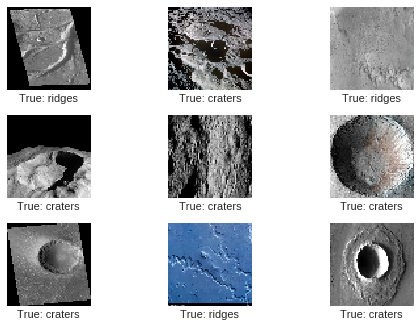

In [220]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [0]:
#weight and biases functions from tensorflow functions

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
#Function for convolutional layer

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [0]:
#Function that defines the flatten layer in your network

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [0]:
#Function which defines a fully connected layer in your network

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [0]:
#Define x and y values for network
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [226]:
#Convolutional Layer 1
#num_channels = 3 (red, greed, blue) (RGB), filter size = 5, pooling

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu_21:0' shape=(?, 32, 32, 64) dtype=float32>

In [0]:
#Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [228]:
#Flat Layer
layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat, num_features)

(<tf.Tensor 'Reshape_15:0' shape=(?, 16384) dtype=float32>, 16384)


In [229]:
#Fully Connected Layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc1_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_23:0' shape=(?, 128) dtype=float32>

In [230]:
#Fully Connected Layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc1_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_31:0' shape=(?, 2) dtype=float32>

In [0]:
#Prediction Outputs using Softmax decision
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [0]:
#Cost, Entropy and Optimizer SEttins
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [0]:
#Prediction and Accuracy Setting to tensorflow functions
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
#Initialize Tensorflow session
session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = batch_size

In [0]:
#Helper function which prints the training progress of accuracy and loss

def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [0]:
# Counter for total number of iterations performed so far.
total_iterations = 0

# Function which runs the training process 
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [237]:
#THIS STEP RUNS YOUR MODEL TO TEST TRAINING AND VALIDATION ACCURACY

#Improving accuracy here is quite difficult as you need to have an indepth understanding of how and why different convolutional, fully connection and pooling layers are used
#Depending on the image types you use it will converge faster than 100 iterations e.g. 25

optimize(num_iterations=100)


Epoch 1 --- Training Accuracy:  50.0%, Validation Accuracy:  40.0%, Validation Loss: 0.726
Epoch 2 --- Training Accuracy:  50.0%, Validation Accuracy:  40.0%, Validation Loss: 0.798
Epoch 3 --- Training Accuracy:  60.0%, Validation Accuracy:  60.0%, Validation Loss: 0.699
Epoch 4 --- Training Accuracy:  70.0%, Validation Accuracy:  40.0%, Validation Loss: 0.750
Epoch 5 --- Training Accuracy:  60.0%, Validation Accuracy:  40.0%, Validation Loss: 0.813
Epoch 6 --- Training Accuracy:  70.0%, Validation Accuracy:  40.0%, Validation Loss: 0.778
Epoch 7 --- Training Accuracy:  70.0%, Validation Accuracy:  40.0%, Validation Loss: 0.766
Epoch 8 --- Training Accuracy:  70.0%, Validation Accuracy:  40.0%, Validation Loss: 0.796
Epoch 9 --- Training Accuracy:  70.0%, Validation Accuracy:  40.0%, Validation Loss: 0.814
Epoch 10 --- Training Accuracy:  70.0%, Validation Accuracy:  40.0%, Validation Loss: 0.809
Epoch 11 --- Training Accuracy:  80.0%, Validation Accuracy:  40.0%, Validation Loss: 0.8

In [0]:
#Test Data and Validation loss and accuracy output
x_test = data.valid.images.reshape(13, img_size_flat)

feed_dict_test = {x: x_test, y_true: data.valid.labels}

val_loss = session.run(cost, feed_dict=feed_dict_test)

val_acc = session.run(accuracy, feed_dict=feed_dict_test)

An accuracy better than 60%? (AMAZING!), the training data you use will drastically effect this, if you only have lets say photos of your dog and one type of cat the accuracy should be quite high but if you were to test against another type of dog with cat like features it would probably be classified incorrectly.

In [242]:
#Print Test Accuracy
msg_test = "Test Accuracy: {0:>6.1%}"
print(msg_test.format(val_acc))

Test Accuracy:  38.5%


In [91]:
# This step can be used to save your model so it can be used later on.
# Store the model
# Save the model for future predicting
saver = tf.train.Saver()

save_dir = './model/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
checkpoint_path = os.path.join(save_dir, 'model')
save_path=saver.save(session, checkpoint_path)
print ('Model saved in file: %s'% save_path)

KeyboardInterrupt: ignored

In [0]:
saver = tf.train.import_meta_graph('./model/model.meta')

saver.restore(session, tf.train.latest_checkpoint('./model/'))

filename = 'images/bunny/enhanced-buzz-504-1296591038-21.jpg'

image_size = 64
num_channels = 3
images = []

# Resizing the image to our desired size and
# preprocessing will be done exactly as done during training
# image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
# images.append(image)

image = cv2.imread(filename)
image = cv2.resize(image, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
images.append(image)

images = np.array(images, dtype=np.uint8)
images = images.astype('float32')
images = np.multiply(images, 1.0/255.0) 

#The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
# x_batch = images.reshape(1, image_size,image_size,num_channels)
x_batch = images.reshape(1, img_size_flat)
 
graph = tf.get_default_graph()

print(tf.global_variables())
 
y_pred = graph.get_tensor_by_name("y_true:0")
 
## Let's feed the images to the input placeholders
x= graph.get_tensor_by_name("x:0") 
y_true = graph.get_tensor_by_name("y_true:0") 
y_test_images = np.zeros((1, 2)) 
 
feed_dict_testing = {x: x_batch, y_true: y_test_images}
result=session.run(y_pred, feed_dict=feed_dict_testing)

print(result)

INFO:tensorflow:Restoring parameters from ./model/model
[<tf.Variable 'Variable:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'Variable_3:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_4:0' shape=(16384, 128) dtype=float32_ref>, <tf.Variable 'Variable_5:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Variable_6:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'Variable_7:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'Variable/Adam:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'Variable/Adam_1:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'Variable_1/Adam:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_1/Adam_1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_2/Adam:0' shape=(3, 3, 